In [1]:
# -*- coding: utf-8 -*-

## Map Generalization for Polygons using Autoencode-like strucutures
## Adatped based on Master Thesis of SERCAN CAKIR "ROAD NETWORK EXTRACTION USING CNN"
## Author: Yu Feng, yuzz.feng@gmail.com
## 1. Version Author: SERCAN CAKIR

## Changes:
## 1. Two conv layers were added before the first down convlusional layer
## 2. Output can be any size during the evaluation
## 3. Adapt the code to support more images as training examples

import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from numpy import random
np.random.seed(7)
import keras
from keras.models import Sequential
from keras.callbacks import History
from keras.layers.core import Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation
from keras import backend as K

from osgeo import gdal
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

# function to read .tif image files
def readImg(img):
    # Read heatmap
    image = gdal.Open(img)
    # Get band of heatmap, it's gray scale image!
    img_band = image.GetRasterBand(1)
    # Read the image as array
    image = img_band.ReadAsArray()
    # Normalize the pixel values in the range 0-1 acc. to max. normalization
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype('float32')


# function to read .tif image files
def readImgInv(img):
    # Read heatmap
    image = gdal.Open(img)
    # Get band of heatmap, it's gray scale image!
    img_band = image.GetRasterBand(1)
    # Read the image as array
    image = img_band.ReadAsArray()
    # Normalize the pixel values in the range 0-1 acc. to max. normalization
    image = (image - image.min()) / (image.max() - image.min())
    
    return image.astype('float32')


# function to create image patches
def imagePatches(img1, p_w, p_h, stride):
    img_1 = view_as_windows(img1, (p_w, p_h), stride)
    a, b, h, w = img_1.shape
    img_1_1 = np.reshape(img_1, (a * b, p_w, p_h))
    return img_1_1

# functions to remove fully black images from heatmap and target data, and all the correspondences
def removeBlackImg(img_patch):
    patch_list = []
    patch_list_new = []
    for i in range(len(img_patch)):
        patch_list.append(img_patch[i])
        if patch_list[i].max() != 0:
            patch_list_new.append(img_patch[i])
    return patch_list_new

# remove roads if heats are black
def removeCorrespondence(road, heat):  
    patch_road_list = []
    patch_heat_list = []
    patch_road_list_new = []
    for i in range(len(road)):
        patch_road_list.append(road[i])
        patch_heat_list.append(heat[i])
        if patch_heat_list[i].max() != 0:
            patch_road_list_new.append(road[i])
    return patch_road_list_new



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# function to load a saved model
def LoadModel(model_json):
    from keras.models import model_from_json
    json_file = open(model_json)
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model


##### function to calculate evaluation parameters (F1-Score, Precision, Recall) ######
def evaluation(model, x_test, y_test, patch_size):
    precision = []
    recall = []
    f1Score = []
    import math
    for k in range(len(x_test_sim)):
        y_pred = model.predict(x_test_sim[k:k + 1])
        y_pred = np.reshape(y_pred, (32 * 32))

        y_true = y_test_sim[k:k + 1]
        y_true = np.reshape(y_true, (32 * 32))

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        y_pred = np.round(y_pred)
        for i in range(len(y_pred)):
            if y_true[i] == y_pred[i] == 1:
                TP += 1
            elif y_pred[i] == y_true[i] == 0:
                TN += 1
            elif y_pred[i] == 1 and y_true[i] != y_pred[i]:
                FP += 1
            elif y_pred[i] == 0 and y_true[i] != y_pred[i]:
                FN += 1

        precision.append(TP / (TP + FP + K.epsilon()))  # completeness
        recall.append(TP / (TP + FN))  # correctness
        beta = 1
        f1Score.append((math.pow(beta, 2) + 1) * TP / ((math.pow(beta, 2) + 1) * TP + math.pow(beta, 2) * FN + FP))
        # eval_list = [precision,  recall, f1Score]

    avg_precision = sum(precision) / len(precision)
    avg_recall = sum(recall) / len(precision)
    avg_f1score = sum(f1Score) / len(precision)
    avg_eval_param = [avg_precision, avg_recall, avg_f1score]
    return avg_eval_param

In [3]:
## Building the CNN archıtecture with "Sequential Model" (model looks like autoencoder)
## Version with batch normalozation - Do not benifit that much

def create_model_batch(optimizer, input_shape):
    
    model = Sequential()
    droprate = 0.3
    
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              input_shape=input_shape, kernel_initializer='random_uniform', name="flat_conv_a"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same', name="flat_conv_b"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    ## Encoding (down-sampling) ###   
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     name="down_conv_1"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_1"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_2"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    ## Encoding (down-sampling) ### 
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     name="down_conv_2"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_3"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_4"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_5"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6a"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6b"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6c"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_7"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_8"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_1'))
    
    model.add(Conv2D(filters=64, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     name="up_conv_1"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_9"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_10"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_2'))

    model.add(Conv2D(filters=24, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     name="up_conv_2"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_11"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12"))
    # model.add(Activation(our_activation))
    model.add(Dropout(droprate))

    # Compile model with Adam optimizer and binary cross entropy loss function
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [4]:
##### Building the CNN archıtecture with "Sequential Model" 
##### (model looks like autoencoder)
def create_model(optimizer, input_shape):
    model = Sequential()
    
    droprate = 0.3

    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu', input_shape=input_shape, kernel_initializer='random_uniform',
              name="flat_conv_a"))
    #model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu',name="flat_conv_b"))
    #model.add(Dropout(droprate))
    
#    model.add(Conv2D(filters=24, kernel_size=(3, 3),
#              strides=(1, 1), padding='same',
#              activation='relu',name="flat_conv_c"))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
#    model.add(Dropout(droprate))
    
    ## Encoding (down-sampling) ###   
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', #input_shape=input_shape, kernel_initializer='random_uniform',
                     name="down_conv_1"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_1"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_2"))
    #model.add(Dropout(droprate))
    ##############################################################################
    
#    model.add(Conv2D(filters=24, kernel_size=(3, 3),
#              strides=(1, 1), padding='same',
#              activation='relu',name="down_conv_2"))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
#    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', name="down_conv_2"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_3"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_4"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_5"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_6"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_7"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8"))
    #model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_1'))
    
#    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), 
#                              padding='same', activation='softmax'))
    

    model.add(Conv2D(filters=64, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_1"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_9"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_10"))
    #model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_2'))
    
#    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), # Lead the accuracy to 0.78
#                              padding='same', activation='softmax'))

    model.add(Conv2D(filters=24, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_2"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12"))
    # model.add(Activation(our_activation))
    #model.add(Dropout(droprate))

    # Compile model with Adam optimizer and binary cross entropy loss function
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model


# model_ex1.summary()

##################################################################################################################################
#class Covariance(keras.callbacks.Callback):
#
#    def on_train_begin(self, logs={}):
#        self.avg_cov1 = []
#        self.avg_cov2 = []
#
#    def on_epoch_end(self, epoch, logs={}):
#        x_val1, y_true1 = x_train_sim, y_train_sim
#        y_pred1 = self.model.predict(x_val1)
#
#        x_val2, y_true2 = x_test_sim, y_test_sim
#        y_pred2 = self.model.predict(x_val2)
#
#        cov_1 = []
#        max_cov1 = []
#        for i in range(len(y_pred1)):
#            y_pred_clip1 = np.reshape(y_pred1[i][1:(len(y_pred1[1]) - 1), 1:(len(y_pred1[1]) - 1)],
#                                      ((len(y_pred1[1]) - 2) ** 2, 1))  # (len(y_pred1)-1)=31
#            y_true_1 = imagePatches(np.reshape(y_true1[i], (len(y_pred1[1]), len(y_pred1[1]))), (len(y_pred1[1]) - 2),
#                                    (len(y_pred1[1]) - 2), 1)
#            for k in range(0, 9):
#                cov_1.append(sum((y_pred_clip1 - y_pred_clip1.mean()) * (
#                            np.reshape(y_true_1[k], ((len(y_pred1[1]) - 2) ** 2, 1)) - (
#                        np.reshape(y_true_1[k], ((len(y_pred1[1]) - 2) ** 2, 1)).mean()))) / len(
#                    y_pred_clip1))  # 900
#        for j in range(0, 9 * len(y_pred1), 9):
#            max_cov1.append(max(cov_1[j:j + 9]))
#
#        cov_2 = []
#        max_cov2 = []
#        for i in range(len(y_pred2)):
#            y_pred_clip2 = np.reshape(y_pred2[i][1:(len(y_pred2[1]) - 1), 1:(len(y_pred2[1]) - 1)],
#                                      ((len(y_pred2[1]) - 2) ** 2, 1))  # (len(y_pred1)-1)=31
#            y_true_2 = imagePatches(np.reshape(y_true2[i], (len(y_pred2[1]), len(y_pred2[1]))), (len(y_pred2[1]) - 2),
#                                    (len(y_pred2[1]) - 2), 1)
#            for k in range(0, 9):
#                cov_2.append(sum((y_pred_clip2 - y_pred_clip2.mean()) * (
#                            np.reshape(y_true_2[k], ((len(y_pred2[1]) - 2) ** 2, 1)) - (
#                        np.reshape(y_true_2[k], ((len(y_pred2[1]) - 2) ** 2, 1)).mean()))) / len(
#                    y_pred_clip2))  # 900
#        for j in range(0, 9 * len(y_pred2), 9):
#            max_cov2.append(max(cov_2[j:j + 9]))
#        print('\n avg_cov: {} - val_avg_cov: {}\n'.format(np.mean(max_cov1), np.mean(max_cov2)))
#
#        self.avg_cov1.append(np.mean(max_cov1))
#        self.avg_cov2.append(np.mean(max_cov2))


##################################################################################################################################
class LearningRateTracker(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lr_list = []

    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        # lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        lr = K.eval(
            optimizer.lr * (1. / (1. + optimizer.decay * K.cast(optimizer.iterations, K.dtype(optimizer.decay)))))
        print('\n LR: {}\n'.format(lr))
        self.lr_list.append(lr)

##################################################################################################################################
class SaveWeights(keras.callbacks.Callback):  # Saves weights after each 25 epochs
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 49 == 0:
            model_json = self.model.to_json()
            with open("model_" + str(epoch) + ".json", "w") as json_file:
                json_file.write(model_json)
            self.model.save_weights("weights_model_" + str(epoch) + ".h5")
            print("Saved model-weights to disk")

##################################################################################################################################

Number of tiles:  1481
1281 200 1281 200
Input Shape of the models (1281, 128, 128, 1)


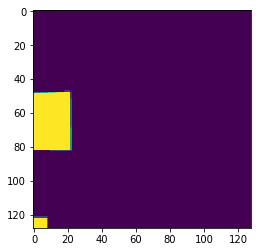

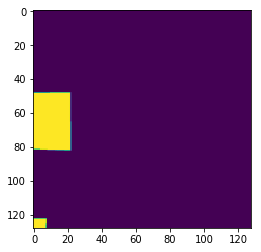

In [5]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

# set the working directory
#os.chdir(r'F:\sercan\input_images')
PATH = os.getcwd()
#plt.gray()
#plt.show()


p_size_1 = 128 # Compared with 256, which larger may generate round corners

def data_collector(fns_input, fns_output):
    
    sim_input = []
    sim_output = []
    
    for fn_input, fn_output in zip(fns_input, fns_output):
        
        # load simulated heat map (TRAJECTORY SIMULATION) and target road for Hannover ####
        sim_heatmap_hannover = readImg(fn_input)
        sim_road_hannover = readImg(fn_output)
        
        sim_hm_patches_overlap = imagePatches(sim_heatmap_hannover, p_size_1, p_size_1, int(p_size_1 / 2))
        sim_road_patches_overlap = imagePatches(sim_road_hannover, p_size_1, p_size_1, int(p_size_1 / 2))
        sim_road_patches_overlap_new = removeCorrespondence(sim_road_patches_overlap, sim_hm_patches_overlap)
        sim_hm_patches_overlap_new = removeCorrespondence(sim_hm_patches_overlap, sim_road_patches_overlap)
        sim_road_patches_overlap_new_new = removeBlackImg(sim_road_patches_overlap)
        
        sim_input += sim_hm_patches_overlap_new
        sim_output += sim_road_patches_overlap_new_new
    
    return sim_input, sim_output

fns_input = [r"data/input2.tif"]#, r"data/geb1_inp_inv_cut.tif"]
fns_output = [r"data/output2.tif"]#, r"data/geb1_out_inv_cut.tif"]
sim_hm_patches_32_new, sim_road_patches_32_new_new = data_collector(fns_input, fns_output)


### load simulated heat map (TRAJECTORY SIMULATION) and target road for Hannover ####
##sim_heatmap_hannover = readImg(r"data/input2.tif")
##sim_road_hannover = readImg(r"data/output2.tif")

##sim_hm_patches_overlap = imagePatches(sim_heatmap_hannover, p_size_1, p_size_1, int(p_size_1 / 2))
##sim_road_patches_overlap = imagePatches(sim_road_hannover, p_size_1, p_size_1, int(p_size_1 / 2))
##sim_road_patches_overlap_new = removeCorrespondence(sim_road_patches_overlap, sim_hm_patches_overlap)
##sim_hm_patches_overlap_new = removeCorrespondence(sim_hm_patches_overlap, sim_road_patches_overlap)
##sim_road_patches_overlap_new_new = removeBlackImg(sim_road_patches_overlap)

####sim_hm_patches_32_new = sim_hm_patches_32_new + sim_hm_patches_overlap_new
####sim_road_patches_32_new_new = sim_road_patches_32_new_new + sim_road_patches_overlap_new_new

##sim_hm_patches_32_new = sim_hm_patches_overlap_new
##sim_road_patches_32_new_new = sim_road_patches_overlap_new_new

print('Number of tiles: ', len(sim_hm_patches_32_new))


#### experience 1 - simulated hm
index_list_sim = list(range(len(sim_hm_patches_32_new)))
random.shuffle(index_list_sim)

idx_sim = 200
index_list_test_sim = index_list_sim[-idx_sim:]
index_list_test_sim.sort()
sim_hm_test = [sim_hm_patches_32_new[i] for i in index_list_test_sim]
sim_road_test = [sim_road_patches_32_new_new[i] for i in index_list_test_sim]

index_list_train_sim = index_list_sim[:-idx_sim]
index_list_train_sim.sort()
sim_hm_train = [sim_hm_patches_32_new[i] for i in index_list_train_sim]
sim_road_train = [sim_road_patches_32_new_new[i] for i in index_list_train_sim]

from sklearn.model_selection import train_test_split
#sim_hm_train, sim_hm_test, sim_road_train, sim_road_test = train_test_split(sim_hm_patches_32_new, 
#                                                                            sim_road_patches_32_new_new,
#                                                                            test_size=0.33, random_state=42)

print(len(sim_hm_train), len(sim_hm_test), len(sim_road_train), len(sim_road_test))

x_train_sim = np.reshape(sim_hm_train, (len(sim_hm_train), p_size_1, p_size_1, 1))
y_train_sim = np.reshape(sim_road_train, (len(sim_road_train), p_size_1, p_size_1, 1))
x_test_sim = np.reshape(sim_hm_test, (len(sim_hm_test), p_size_1, p_size_1, 1))
y_test_sim = np.reshape(sim_road_test, (len(sim_road_test), p_size_1, p_size_1, 1))

# save image patch arrays
np.save("x_train_sim.npy", x_train_sim)
np.save("y_train_sim.npy", y_train_sim)
np.save("x_test_sim.npy", x_test_sim)
np.save("y_test_sim.npy", y_test_sim)

plt.figure()
plt.imshow(np.reshape(x_test_sim[2], (p_size_1,p_size_1)))
plt.figure()
plt.imshow(np.reshape(y_test_sim[2], (p_size_1,p_size_1)))

input_shape1 = (None, None, 1) #x_train_sim[0].shape
print('Input Shape of the models', x_train_sim.shape)

opt1 = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
model_ex1 = create_model(opt1, input_shape1)

#model_ex1 = create_model_batch(opt1, input_shape1)

In [6]:
##### Train the model
#covariance1 = Covariance()
History1 = History()
hist1 = model_ex1.fit(x_train_sim, y_train_sim,
                      batch_size=16,
                      epochs=300,
                      verbose=1,
                      shuffle=True,
                      callbacks=[History1],
                      validation_data=(x_test_sim, y_test_sim))

### Save history
History1_loss = History1.history['loss']
History1_acc = History1.history['acc']
History1_val_loss = History1.history['val_loss']
History1_val_acc = History1.history['val_acc']

thefile1 = open('History1_loss.txt', 'w')
for item in History1_loss:
    thefile1.write("%s\n" % item)

thefile2 = open('History1_acc.txt', 'w')
for item in History1_acc:
    thefile2.write("%s\n" % item)

thefile3 = open('History1_val_loss.txt', 'w')
for item in History1_val_loss:
    thefile3.write("%s\n" % item)

thefile4 = open('History1_val_acc.txt', 'w')
for item in History1_val_acc:
    thefile4.write("%s\n" % item)

### Save model
model_json1 = model_ex1.to_json()
with open("model_ex1.json", "w") as json_file:
    json_file.write(model_json1)
model_ex1.save_weights("weights_model_ex1.h5")
print("Saved model to disk")

Train on 1281 samples, validate on 200 samples
Epoch 1/300
1281/1281 [==============================] - 11s 9ms/step - loss: 0.3562 - acc: 0.8586 - val_loss: 0.0942 - val_acc: 0.9521
Epoch 2/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0935 - acc: 0.9483 - val_loss: 0.0772 - val_acc: 0.9556
Epoch 3/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0828 - acc: 0.9529 - val_loss: 0.0630 - val_acc: 0.9616
Epoch 4/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0731 - acc: 0.9564 - val_loss: 0.0576 - val_acc: 0.9624
Epoch 5/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0695 - acc: 0.9577 - val_loss: 0.1129 - val_acc: 0.9469
Epoch 6/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0640 - acc: 0.9594 - val_loss: 0.0749 - val_acc: 0.9550
Epoch 7/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0629 - acc: 0.9597 - val_loss: 0.0620 - val_acc: 0.9606
Epoch 8

Epoch 61/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0369 - acc: 0.9663 - val_loss: 0.0339 - val_acc: 0.9678
Epoch 62/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0365 - acc: 0.9664 - val_loss: 0.0351 - val_acc: 0.9675
Epoch 63/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0366 - acc: 0.9664 - val_loss: 0.0397 - val_acc: 0.9663
Epoch 64/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0360 - acc: 0.9665 - val_loss: 0.0497 - val_acc: 0.9625
Epoch 65/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0358 - acc: 0.9666 - val_loss: 0.0368 - val_acc: 0.9672
Epoch 66/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0356 - acc: 0.9666 - val_loss: 0.0324 - val_acc: 0.9681
Epoch 67/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0355 - acc: 0.9667 - val_loss: 0.0336 - val_acc: 0.9679
Epoch 68/300
1281/1281 [========================

1281/1281 [==============================] - 6s 5ms/step - loss: 0.0257 - acc: 0.9692 - val_loss: 0.0330 - val_acc: 0.9692
Epoch 122/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0257 - acc: 0.9692 - val_loss: 0.0284 - val_acc: 0.9689
Epoch 123/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0254 - acc: 0.9693 - val_loss: 0.0251 - val_acc: 0.9699
Epoch 124/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0254 - acc: 0.9693 - val_loss: 0.0276 - val_acc: 0.9698
Epoch 125/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0254 - acc: 0.9693 - val_loss: 0.0262 - val_acc: 0.9698
Epoch 126/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0251 - acc: 0.9694 - val_loss: 0.0273 - val_acc: 0.9697
Epoch 127/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0250 - acc: 0.9694 - val_loss: 0.0275 - val_acc: 0.9692
Epoch 128/300
1281/1281 [==============================

Epoch 181/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0214 - acc: 0.9703 - val_loss: 0.0209 - val_acc: 0.9709
Epoch 182/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0210 - acc: 0.9703 - val_loss: 0.0214 - val_acc: 0.9707
Epoch 183/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0211 - acc: 0.9703 - val_loss: 0.0252 - val_acc: 0.9701
Epoch 184/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0213 - acc: 0.9703 - val_loss: 0.0242 - val_acc: 0.9708
Epoch 185/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0212 - acc: 0.9703 - val_loss: 0.0213 - val_acc: 0.9708
Epoch 186/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0212 - acc: 0.9703 - val_loss: 0.0242 - val_acc: 0.9702
Epoch 187/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0213 - acc: 0.9703 - val_loss: 0.0210 - val_acc: 0.9709
Epoch 188/300
1281/1281 [================

Epoch 241/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0192 - acc: 0.9707 - val_loss: 0.0203 - val_acc: 0.9711
Epoch 242/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0192 - acc: 0.9707 - val_loss: 0.0206 - val_acc: 0.9711
Epoch 243/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0191 - acc: 0.9707 - val_loss: 0.0199 - val_acc: 0.9711
Epoch 244/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0192 - acc: 0.9707 - val_loss: 0.0236 - val_acc: 0.9707
Epoch 245/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0193 - acc: 0.9707 - val_loss: 0.0197 - val_acc: 0.9712
Epoch 246/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0190 - acc: 0.9707 - val_loss: 0.0196 - val_acc: 0.9713
Epoch 247/300
1281/1281 [==============================] - 6s 5ms/step - loss: 0.0190 - acc: 0.9707 - val_loss: 0.0215 - val_acc: 0.9710
Epoch 248/300
1281/1281 [================

Saved model to disk


(1556, 2083)


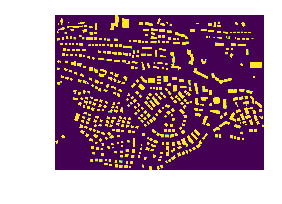

In [7]:
image_arr = readImg(r"testexampleinput2.tif")
print(image_arr.shape)

conc2 = np.reshape(model_ex1.predict(np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))), 
                   (image_arr.shape[0], image_arr.shape[1] + 1))

fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(conc2)
#ax.imshow(conc2, aspect='normal')
fig.savefig("OutputTest", dpi=1000)

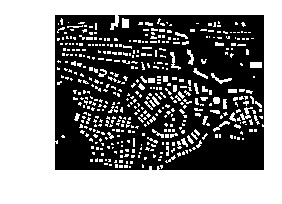

In [8]:
fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
conc2 = conc2>0.2
plt.imshow(conc2, cmap='gray')
#ax.imshow(conc2, aspect='normal')
fig.savefig("OutputTest_BW", dpi=1000)

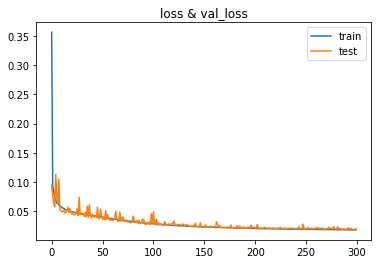

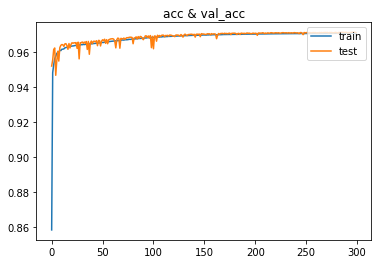

In [9]:
### Plot history of average covariance - accuracy and loss of the models
plt.figure()
plt.plot(History1.history['loss'])
plt.plot(History1.history['val_loss'])
plt.title('loss & val_loss')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("loss", dpi=1000)

plt.figure()
plt.plot(History1.history['acc'])
plt.plot(History1.history['val_acc'])
plt.title('acc & val_acc')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("acc", dpi=1000)